# [DoWhy](https://github.com/py-why/dowhy)

Kompletny framework wnioskowania przyczynowego oparty na grafach DAG. 

## 1. Instalacja 

In [18]:
%pip install dowhy
%pip install pygraphviz
%pip install pandas

You should consider upgrading via the '/home/natalia/wsi/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/home/natalia/wsi/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/home/natalia/wsi/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## 2. Przygotowanie danych 

In [19]:
import pandas as pd

url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"

df = pd.read_csv(url)

In [20]:
df['Cabin'].isnull().sum() # 687 z 891 wartości jest pustych, pominę tę kolumnę 

687

In [21]:
df['Ticket'] # nie można w łatwy sposób podzielić na kategorię, też pomijam  

0             A/5 21171
1              PC 17599
2      STON/O2. 3101282
3                113803
4                373450
             ...       
886              211536
887              112053
888          W./C. 6607
889              111369
890              370376
Name: Ticket, Length: 891, dtype: object

In [22]:
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
df = df[features + ['Survived']]


df.dropna(inplace=True)
df = df.astype({"Age": int})
df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,male,22,1,0,7.2500,S,0
1,1,female,38,1,0,71.2833,C,1
2,3,female,26,0,0,7.9250,S,1
3,1,female,35,1,0,53.1000,S,1
4,3,male,35,0,0,8.0500,S,0


In [23]:
%%capture --no-display
df.loc[:, 'Sex']= df['Sex'].astype('category').cat.codes 
df.loc[:,'Embarked'] = df['Embarked'].astype('category').cat.codes 

In [24]:
df.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
0,3,1,22,1,0,7.2500,2,0
1,1,0,38,1,0,71.2833,0,1
2,3,0,26,0,0,7.9250,2,1
3,1,0,35,1,0,53.1000,2,1
4,3,1,35,0,0,8.0500,2,0


## 2. Modelowanie problemu

2024-06-14 07:47:55,488 - /home/natalia/wsi/venv/lib/python3.9/site-packages/dowhy/causal_model.py[line:76] - WARNING: Causal Graph not provided. DoWhy will construct a graph based on data inputs.
2024-06-14 07:47:55,491 - /home/natalia/wsi/venv/lib/python3.9/site-packages/dowhy/causal_model.py[line:482] - INFO: Model to find the causal effect of treatment ['Pclass'] on outcome ['Survived']


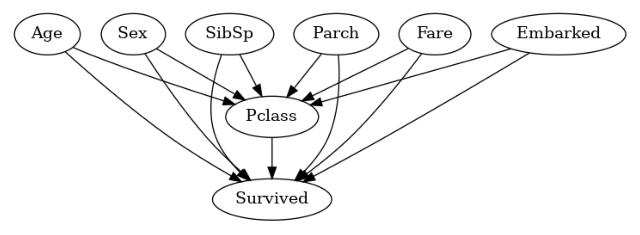

In [25]:
from dowhy import CausalModel


model = CausalModel(
    data=df,
    treatment='Pclass',
    outcome='Survived',
    common_causes=['Age', 'Sex', 'SibSp', 'Parch', 'Fare', 'Embarked']
)

model.view_model()

## Identyfikacja estymand

Biblioteka DoWhy wyświetla 3 różne estymandy. Najpierw wyświetla nazwę estymandy, a za nią informację czy w przykładowym znaleziono dany typ estymandy. 

Szacowanie efektu przyczynowego ma na celu uchwycenie siły (oczekiwanej) zmiany w zmiennej wynikowej, gdy zmieniamy wartość zmiennej traktowanej (zmiennej przyczynowej) o jedną jednostkę.

2024-06-14 07:47:55,746 - /home/natalia/wsi/venv/lib/python3.9/site-packages/dowhy/causal_identifier/auto_identifier.py[line:763] - INFO: Causal effect can be identified.
2024-06-14 07:47:55,755 - /home/natalia/wsi/venv/lib/python3.9/site-packages/dowhy/causal_identifier/auto_identifier.py[line:260] - INFO: Instrumental variables for treatment and outcome:[]
2024-06-14 07:47:55,757 - /home/natalia/wsi/venv/lib/python3.9/site-packages/dowhy/causal_identifier/auto_identifier.py[line:275] - INFO: Frontdoor variables for treatment and outcome:[]


2024-06-14 07:47:55,762 - /home/natalia/wsi/venv/lib/python3.9/site-packages/dowhy/causal_model.py[line:310] - INFO: linear_regression
2024-06-14 07:47:55,764 - /home/natalia/wsi/venv/lib/python3.9/site-packages/dowhy/causal_estimators/linear_regression_estimator.py[line:70] - INFO: INFO: Using Linear Regression Estimator
2024-06-14 07:47:55,771 - /home/natalia/wsi/venv/lib/python3.9/site-packages/dowhy/causal_estimators/regression_estimator.py[line:98] - INFO: b: Survived~Pclass+Embarked+Fare+Sex+Parch+SibSp+Age


Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                                   
─────────(E[Survived|Embarked,Fare,Sex,Parch,SibSp,Age])
d[Pclass]                                               
Estimand assumption 1, Unconfoundedness: If U→{Pclass} and U→Survived then P(Survived|Pclass,Embarked,Fare,Sex,Parch,SibSp,Age,U) = P(Survived|Pclass,Embarked,Fare,Sex,Parch,SibSp,Age)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                                   
─────────(E[Survived|Embarked,Fare,Sex,Parch,SibSp,Age])
d[Pclass]                                               
Estimand assumption 1, Unconfoundedness: If U→{Pclass} and U→Survived the

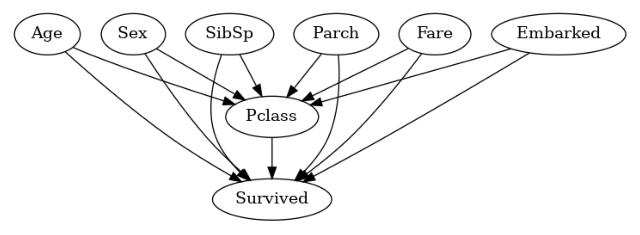

In [26]:
identified_estimand = model.identify_effect()

print(identified_estimand)

estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.linear_regression")

print(estimate)

model.view_model(layout="dot")

## Testy obalające (refutation tests)

Testy te sprawdzają ogólną poprawność struktury modelu, ale nie mówią zbyt wiele o tym, jak dobre jest uzyskane oszacowanie. 

### Test data_subset_refuter

Test ten usuwa losowy podzbiór danych i ponownie szacuje efekt przyczynowy. Oczekuje, że nowe oszacowanie (na podzbiorze danych) nie powinno znacząco różnić się od pierwotnego. 

In [10]:
refute_subset = model.refute_estimate(
    estimand=identified_estimand, 
    estimate=estimate, 
    method_name="data_subset_refuter", 
    subset_fraction=0.3
)
print(refute_subset)

Refute: Use a subset of data
Estimated effect:-0.1904143718488408
New effect:-0.1984573740486131
p value:0.9



Pierwotne oszacowanie i oszacowanie po modyfikacji są bardzo zbliżone, wartość p jest wysoka, co wskazuje, że prawdopdobnie między tymi dwoma oszacowaniami nie ma istotnej różnicy. Wynik ten daje nieco więcej pewności, że zaproponowany model może być poprawny. 

### Losowa wspólna przyczyna 



In [11]:
random_cause = model.refute_estimate(
    estimand=identified_estimand, 
    estimate=estimate, 
    method_name="random_common_cause", 
    subset_fraction=0.3
)
print(refute_subset)

Refute: Use a subset of data
Estimated effect:-0.1904143718488408
New effect:-0.1984573740486131
p value:0.9



### Losowa zmienna placebo 



In [12]:
placebo_refuter = model.refute_estimate(
    estimand=identified_estimand, 
    estimate=estimate, 
    method_name="placebo_treatment_refuter", 
    subset_fraction=0.3
)
print(placebo_refuter)

Refute: Use a Placebo Treatment
Estimated effect:-0.1904143718488408
New effect:0.0005796708667812256
p value:0.94



Wartość p-value = 0.98 wskazuje na brak istotnych zmian w efekcie przyczynowym po wprowadzeniu placebo traktowania, co jest pozytywnym wynikiem w kontekście stabilności oszacowania efektu przyczynowego.

Wynik wskazuje na to, że efekt przyczynowy pozostał zbliżony do wartości pierwotnej. P-value wynoszące 0.92 sugeruje, że różnica między pierwotnie oszacowanym efektem a nowym efektem jest nieistotna statystycznie na poziomie istotności 0.05.

In [13]:
%pip install gcastle

You should consider upgrading via the '/home/natalia/wsi/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## pakiet gCastle

In [14]:
import os
os.environ['CASTLE_BACKEND'] = 'pytorch'

from collections import OrderedDict

import numpy as np
import networkx as nx

from castle.datasets import IIDSimulation, DAG
from castle.algorithms import PC, GES, ICALiNGAM, GOLEM

import matplotlib.pyplot as plt

You are using ``pytorch`` as the backend.


In [15]:
from castle.common.independence_tests import CITest
pc = PC(ci_test=CITest.cressie_read, variant="stable")
pc.learn(df)

# Macierz sąsiedztwa 
print(pc.causal_matrix)

/home/natalia/wsi/venv/lib/python3.9/site-packages/castle/common/independence_tests.py:515: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for z_state, df in data.groupby(z):
/home/natalia/wsi/venv/lib/python3.9/site-packages/castle/common/independence_tests.py:515: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for z_state, df in data.groupby(z):
/home/natalia/wsi/venv/lib/python3.9/site-packages/castle/common/independence_tests.py:515: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this 

[[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 0]]


/home/natalia/wsi/venv/lib/python3.9/site-packages/castle/common/independence_tests.py:515: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for z_state, df in data.groupby(z):
/home/natalia/wsi/venv/lib/python3.9/site-packages/castle/common/independence_tests.py:515: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for z_state, df in data.groupby(z):
/home/natalia/wsi/venv/lib/python3.9/site-packages/castle/common/independence_tests.py:515: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this 

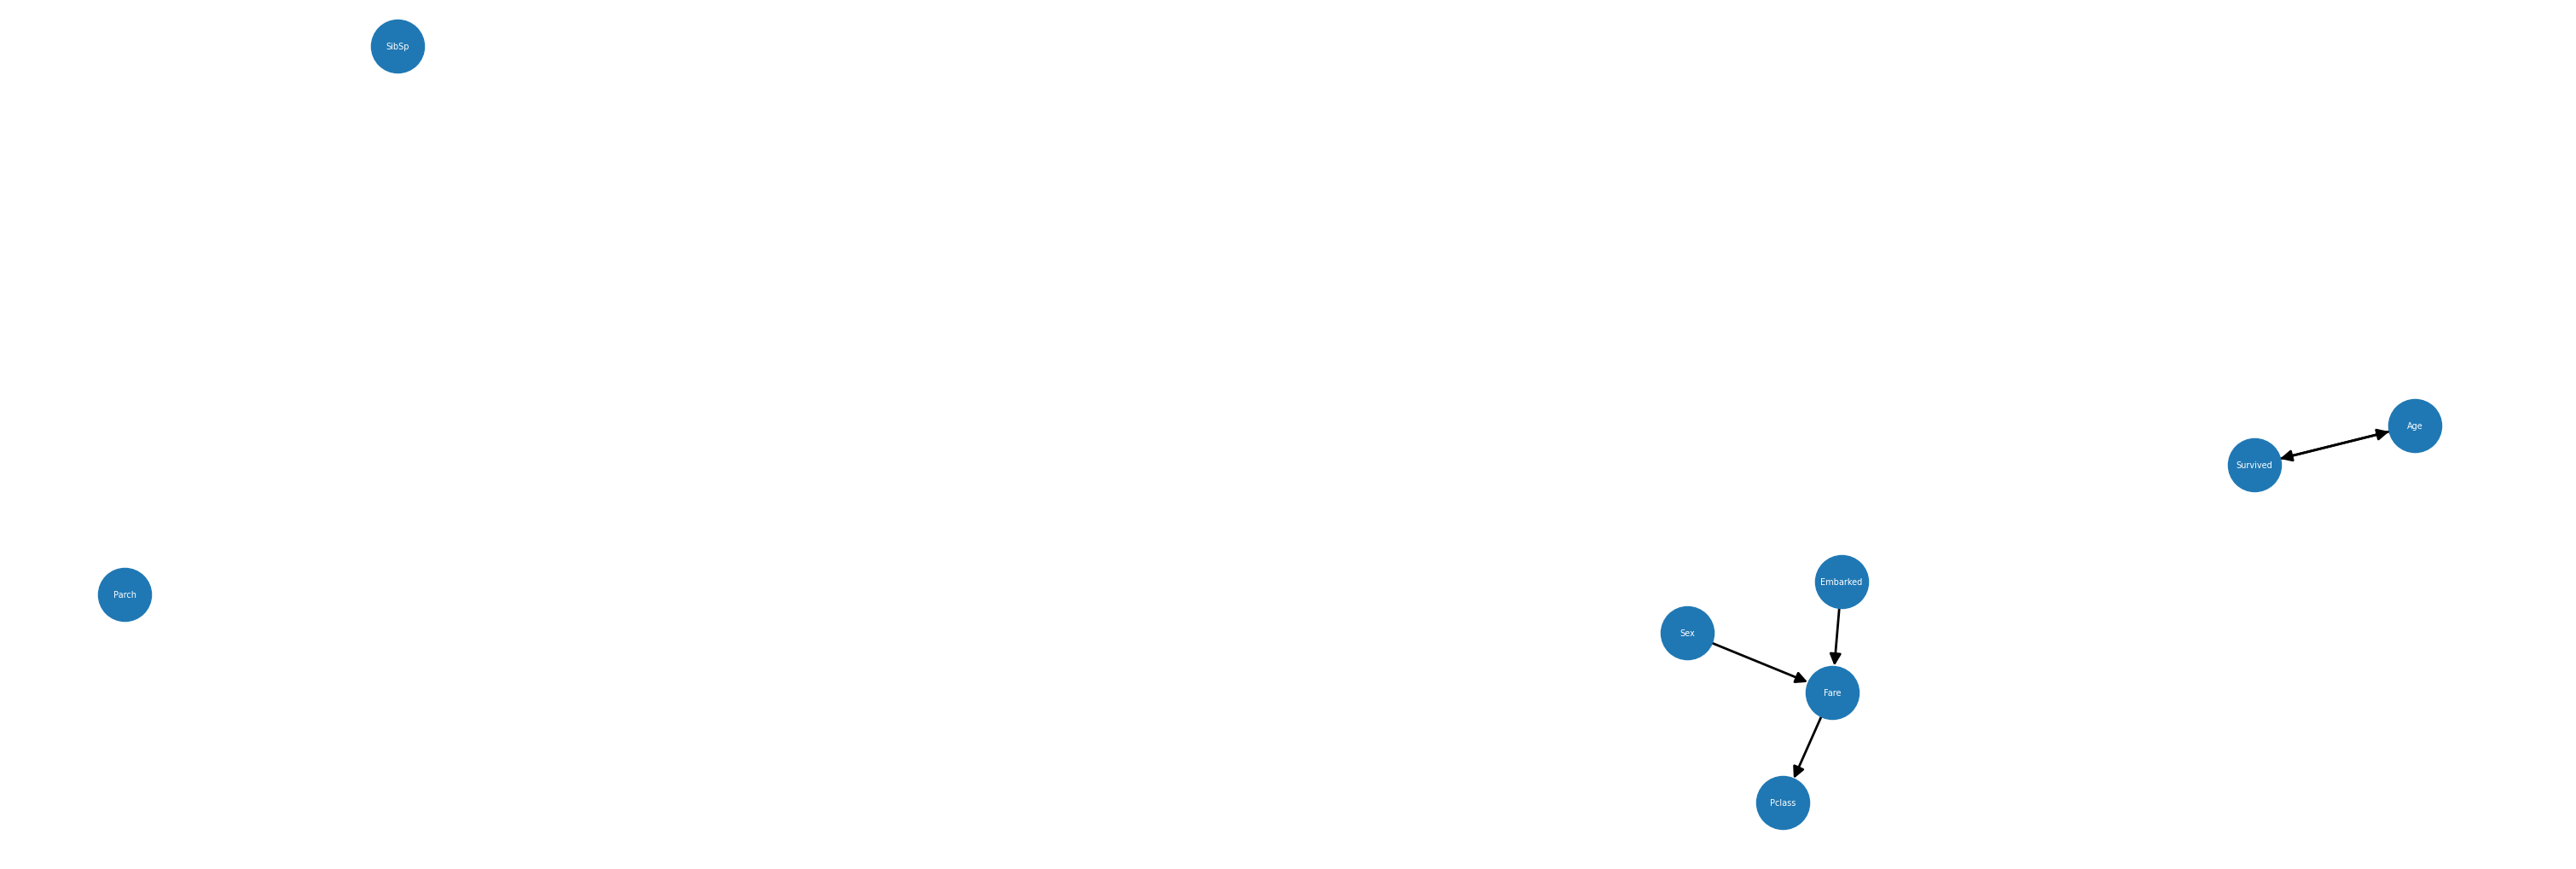

In [16]:
import networkx as nx
import matplotlib.pyplot as plt


learned_graph = nx.DiGraph(pc.causal_matrix)

nodes_labels = {'Pclass': 0, 'Sex': 1, 'Age': 2, 'SibSp': 3, 'Parch': 4, 'Fare': 5, 'Embarked': 6, 'Survived': 7}

node_labels = {v : k for k,v in nodes_labels.items()}

fig = plt.figure(figsize=(30,10))
pos = nx.spring_layout(learned_graph)

nx.draw(
    learned_graph, 
    labels=node_labels,
    node_size=2000,
    font_size=7,
    arrowsize=20,
    width=2, 
    font_color='white',
    pos=pos
)

[[0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 1]
 [0 0 1 0 1 0 0 0]
 [0 1 1 1 0 1 0 0]
 [1 0 1 0 0 0 0 0]
 [1 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0 0]]


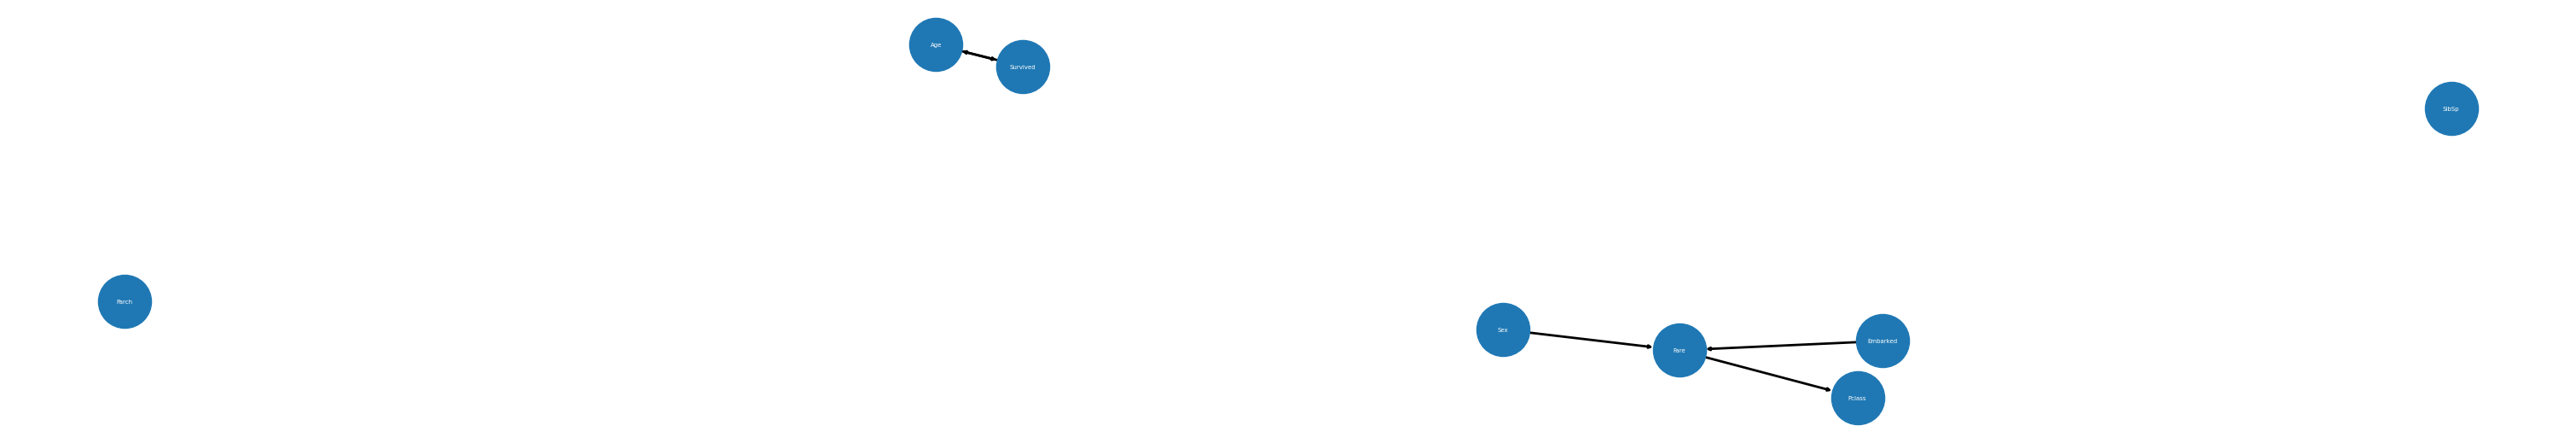

In [17]:
ges = GES(criterion='bic')
ges.learn(df)

learned_graph = nx.DiGraph(pc.causal_matrix)

nodes_labels = {'Pclass': 0, 'Sex': 1, 'Age': 2, 'SibSp': 3, 'Parch': 4, 'Fare': 5, 'Embarked': 6, 'Survived': 7}

node_labels = {v : k for k,v in nodes_labels.items()}

fig = plt.figure(figsize=(30,5))
pos = nx.spring_layout(learned_graph)

nx.draw(
    learned_graph, 
    labels=node_labels,
    node_size=2000,
    font_size=5,
    arrowsize=5,
    width=2, 
    font_color='white',
    pos=pos
)

print(ges.causal_matrix)